# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [329]:
import numpy as np
# import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [330]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [331]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(X.shape)
df = pd.read_csv("data.csv",nrows=5000)

(5000, 400)


In [332]:
df.head()

,13,13.1,13.2,13.3,13.4,13.5,13.6,13.7,13.8,13.9,...,13.211,13.212,13.213,13.214,13.215,13.216,13.217,13.218,13.219,13.220
0,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
1,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
2,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
3,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
4,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11


In [333]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

In [334]:
Y

array([10, 10, 10, ...,  9,  9,  9])

Afficher aléatoirement quelques données de notre base

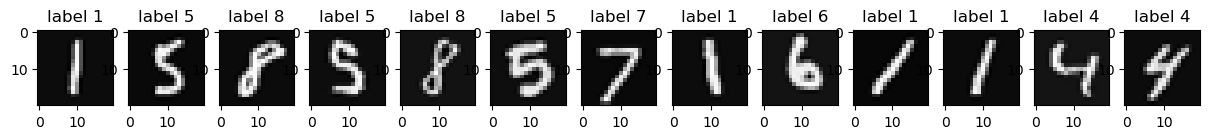

In [335]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    # genere des chiffre aleatoire de 0 a X.shape[0] que veux dire de (0 ,nombre tuple) 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    # les données sont en format plat donc on doit les transformer en 2D
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    # Cette ligne crée un sous-graphique dans une grille d'une ligne et 13 colonnes, puis sélectionne le sous-graphique correspondant à la position actuelle i+1 dans cette grille.
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

In [336]:
def MatriceConf(target, prediction,nCl=11):
    # num_classes = nCl 
    # conf_matrix = [[0] * num_classes for _ in range(num_classes)] #cree une list
    conf_matrix = np.zeros((nCl, nCl)) # creer une matrice de numclasses*numclasses de zero
    for y,pred  in zip(target, prediction):
        conf_matrix[y,pred]+=1 #ligne => Reality.       #colonne => prediction.      
    
    conf_matrix = np.delete(conf_matrix, 0, axis=0)
    conf_matrix = np.delete(conf_matrix, 0, axis=1)
    return conf_matrix


In [337]:
def CM_metrics (conf_matrix):
    # Calculating TP, TN, FP, FN for each class
    tp = np.diag(conf_matrix) #prédit la bonne classe
    fp = (np.sum(conf_matrix, axis=0) - tp) #Lignes : prédit une autre classe que la classe courante
    fn = (np.sum(conf_matrix, axis=1) - tp) #Colonne : prédit la classe courante quand en réalité c'est une autre classe
    tn = (np.sum(conf_matrix) - (tp + fn + fp)) #prédit une autre classe que la classe courante et ce sont effectiviement d'autres classes
  
    return tp, fn, fp, tn

- Accuracy = (TP + TN)/(TP + TN + FP + FN)

In [338]:
def accuracy(tp, fn, fp,tn):
    return ((tp.sum())/(tp.sum()+tn.sum()+fp.sum()+fn.sum()))


- Recall (True Positive Rate) = TP/(TP + FN)

In [339]:
def recall(tp, fn): 
    return ((tp)/(tp+fn))

- Précision = TP/(TP + FP)

In [340]:
def precision(tp, fp):
    return ((tp)/(tp+fp))

- Taux de FP (False Positive Rate) = FP / (FP + TN)

In [341]:
def FP_rate(fp, tn):
    return ((fp)/(fp+tn))

- Spécificité (True Negative Rate) = TN / (TN + FP)

In [342]:
def TN_rate(fp, tn):
    return ((tn)/(tn+fp))

- Courbe ROC

In [378]:
from itertools import cycle
def ROC(fpr, tpr):

    lw = 2
    plt.figure()
    
    n_classes = 10
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green', 'red', 'blue', 'yellow', 'pink', 'brown', 'purple'])
    
    for i, color in zip(range(n_classes), colors):    
        plt.plot(fpr[i], tpr[i], lw = lw, color=color, label='ROC curve of class {0}'''.format(i+1))
            
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc="lower right")

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [344]:
scaler = StandardScaler() #normalisation des données
scaler.fit(X)
scaled_features = scaler.transform(X)
# Applique la transformation de standardisation aux données dans le tableau X. Les données transformées sont stockées dans scaled_features. Chaque fonctionnalité est maintenant standardisée.
Xt, Xtt, Yt, Ytt = train_test_split(scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [345]:
from collections import Counter

def euclidean_distance(x1,x2):
    # parmet de calculer la distance euclidean entre deux point x1 et x2
    return np.sqrt(np.sum((x1-x2)**2))

class my_KNN :
    def __init__(self,k):
        self.k = k
        
    def fit(self , X , Y):
        self.X_train = X
        self.y_train = Y
        
    def predict(self , X ):
        prediction = [self._getdistance(x) for x in X ]
        return prediction
    
    def _getdistance (self, x):
        # calculer la distance entre x et toutes les valeur in X_train
        distance = [euclidean_distance(x,x_train) for x_train in self.X_train]
        
        
        # get the closest k ( tri les distance calculer )
        k_indices = np.argsort(distance)[:self.k] #you get the index of the sorted value 
        k_nearest_lables = [self.y_train[i] for i in k_indices]
        
        
        # majority voye
        most_common = Counter(k_nearest_lables).most_common()
        return most_common[0][0]
        

In [346]:
KNN = my_KNN(5)
KNN.fit(Xt,Yt)
prediction = KNN.predict(Xtt)
print(prediction)

[1, 2, 6, 3, 9, 1, 6, 1, 4, 10, 3, 1, 3, 9, 10, 7, 2, 7, 9, 10, 3, 4, 8, 6, 6, 8, 9, 8, 10, 8, 2, 1, 7, 5, 9, 5, 8, 2, 10, 1, 10, 10, 3, 5, 9, 4, 10, 3, 10, 8, 9, 5, 3, 1, 7, 9, 4, 9, 2, 4, 4, 6, 5, 8, 4, 1, 8, 7, 6, 9, 9, 2, 3, 10, 1, 3, 8, 2, 10, 2, 7, 2, 5, 2, 6, 4, 7, 3, 3, 9, 5, 1, 5, 1, 1, 3, 9, 1, 8, 8, 10, 3, 10, 3, 4, 7, 3, 6, 10, 1, 8, 6, 1, 10, 4, 3, 8, 10, 2, 3, 2, 10, 5, 3, 9, 9, 4, 8, 7, 2, 1, 7, 9, 3, 6, 2, 2, 6, 9, 9, 6, 9, 8, 1, 1, 3, 4, 1, 1, 9, 8, 7, 8, 5, 8, 9, 10, 10, 2, 4, 6, 10, 4, 10, 5, 5, 5, 1, 5, 3, 7, 9, 1, 7, 6, 3, 4, 1, 1, 5, 6, 9, 10, 1, 8, 7, 6, 9, 1, 6, 7, 1, 8, 8, 6, 8, 7, 4, 1, 4, 10, 1, 9, 10, 10, 6, 9, 2, 1, 10, 1, 1, 1, 10, 5, 1, 3, 9, 1, 8, 7, 4, 5, 2, 10, 7, 2, 8, 3, 8, 2, 6, 8, 9, 4, 4, 10, 7, 4, 4, 8, 8, 1, 3, 7, 10, 1, 2, 3, 9, 8, 10, 4, 9, 6, 3, 9, 2, 5, 7, 6, 6, 3, 10, 2, 6, 3, 6, 1, 2, 3, 9, 1, 8, 6, 8, 1, 3, 7, 6, 4, 7, 1, 8, 2, 4, 9, 4, 10, 6, 5, 8, 10, 3, 7, 10, 9, 2, 5, 9, 4, 6, 8, 10, 6, 5, 3, 6, 9, 10, 6, 9, 4, 9, 2, 10, 9, 10, 1, 8, 

In [347]:
Ytt

array([1, 2, 6, ..., 7, 9, 1])

In [348]:
comparisons = prediction == Ytt
print(comparisons)
# Calculer le nombre de True dans le vecteur de comparaisons
nombre_true = np.count_nonzero(comparisons)

# Calculer le nombre de False dans le vecteur de comparaisons
nombre_false = len(comparisons) - nombre_true

print("Nombre de True:", nombre_true)
print("Nombre de False:", nombre_false)

[ True  True  True ...  True  True  True]
Nombre de True: 1308
Nombre de False: 192


# Méthode 1: MVS
Machine à Vecteurs de Support

In [349]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

3


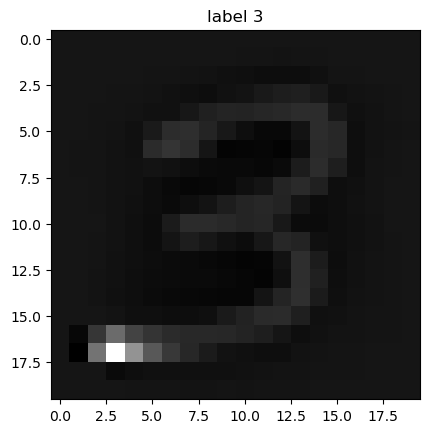

In [350]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 2: Arbres de décision


In [351]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

3


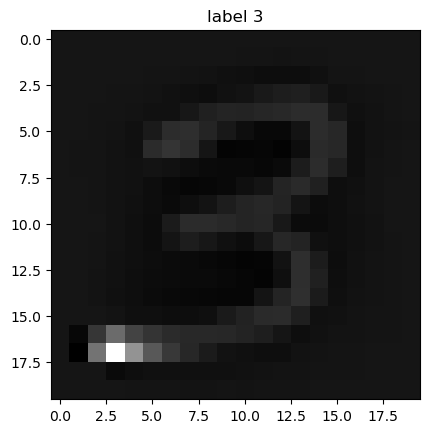

In [352]:
# tester une image
c= 3
print (y_pred[c])
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 3: RN 
Réseaux de neurones Perceptron

In [353]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [354]:
# Choisir un image de test 
c=0

In [355]:
model.predict([Xtt[c,:]])

array([6])

In [356]:
# pour ROC, il faudra les probabilités:
proba = model.predict_proba([Xtt[c,:]])

Afficher l'image testée

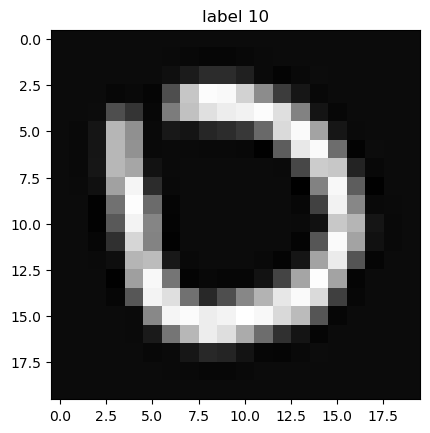

In [357]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat

In [358]:
# Confusion matrix from scratch
conf_matrix= MatriceConf(Yt , y_pred)
conf_matrix

array([[15., 14., 17., 16., 11., 18., 15., 14., 19., 10.],
       [15., 16., 15., 16., 12., 11., 15., 16., 15., 15.],
       [16., 12., 12.,  8., 12., 14., 21., 13., 19., 15.],
       [15., 11., 14., 18., 13., 24., 20., 10., 16., 21.],
       [16., 12., 17., 15.,  9., 15., 18., 14., 19., 14.],
       [20., 14., 16., 16., 13., 11., 19., 16., 18., 14.],
       [18., 16.,  9., 16., 17., 13., 17., 16., 10., 18.],
       [16., 13., 15., 15., 15., 11., 11., 11., 21., 22.],
       [18., 10., 14., 14., 19., 18., 16.,  9., 16., 15.],
       [18., 15.,  7., 13., 15., 14., 13., 16., 20., 15.]])

In [359]:
tp, fn, fp, tn = CM_metrics(conf_matrix)
print(tp,"\n",fn, "\n",fp,"\n",tn,"\n" )

[15. 16. 12. 18.  9. 11. 17. 11. 16. 15.] 
 [134. 130. 130. 144. 140. 146. 133. 139. 133. 131.] 
 [152. 117. 124. 129. 127. 138. 148. 124. 157. 144.] 
 [1199. 1237. 1234. 1209. 1224. 1205. 1202. 1226. 1194. 1210.] 



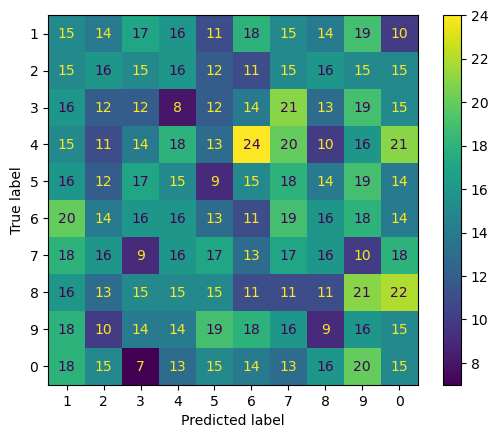

In [360]:
from sklearn import metrics

conf_matrix_display = metrics.ConfusionMatrixDisplay(conf_matrix , display_labels = [1,  2,  3,  4,  5,  6,  7,  8,  9, 0])
conf_matrix_display.plot()
plt.show()

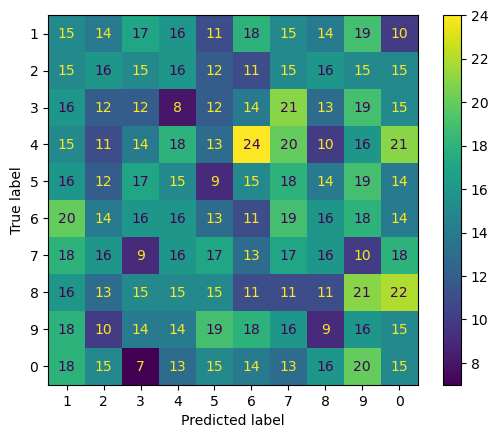

In [361]:
# sklearn confusion matrix
confusion_matrix = confusion_matrix(Yt, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix , display_labels = [1,  2,  3,  4,  5,  6,  7,  8,  9, 0])
cm_display.plot()
plt.show()

In [362]:
recall = recall(tp,fn)
precision = precision(tp,fp)
accuracy = accuracy(tp, fn, fp,tn)

In [363]:
fpr = FP_rate(fp,tn)

In [364]:
print(fpr)

[0.11250925 0.08641064 0.09131075 0.09641256 0.09400444 0.10275503
 0.10962963 0.09185185 0.11621021 0.10635155]


In [365]:
TN_rate(fp,tn)

array([0.88749075, 0.91358936, 0.90868925, 0.90358744, 0.90599556,
       0.89724497, 0.89037037, 0.90814815, 0.88378979, 0.89364845])

In [366]:
print(precision,"\n")
print(recall, "\n")
print(accuracy, "\n")

[0.08982036 0.12030075 0.08823529 0.12244898 0.06617647 0.0738255
 0.1030303  0.08148148 0.09248555 0.09433962] 

[0.10067114 0.10958904 0.08450704 0.11111111 0.06040268 0.07006369
 0.11333333 0.07333333 0.10738255 0.10273973] 

0.009333333333333334 



In [367]:
print(classification_report(Yt, y_pred))

              precision    recall  f1-score   support

           1       0.09      0.10      0.09       149
           2       0.12      0.11      0.11       146
           3       0.09      0.08      0.09       142
           4       0.12      0.11      0.12       162
           5       0.07      0.06      0.06       149
           6       0.07      0.07      0.07       157
           7       0.10      0.11      0.11       150
           8       0.08      0.07      0.08       150
           9       0.09      0.11      0.10       149
          10       0.09      0.10      0.10       146

    accuracy                           0.09      1500
   macro avg       0.09      0.09      0.09      1500
weighted avg       0.09      0.09      0.09      1500



In [368]:
fpr_dict = {}
tpr_dict = {}

for i, value in enumerate(fpr):
    fpr_dict[i] = np.array([0.0, value, 1.0])
    
for i, value in enumerate(recall):
    tpr_dict[i] = np.array([0.0, value, 1.0])
    

print(fpr_dict, "\n", tpr_dict)

{0: array([0.        , 0.11250925, 1.        ]), 1: array([0.        , 0.08641064, 1.        ]), 2: array([0.        , 0.09131075, 1.        ]), 3: array([0.        , 0.09641256, 1.        ]), 4: array([0.        , 0.09400444, 1.        ]), 5: array([0.        , 0.10275503, 1.        ]), 6: array([0.        , 0.10962963, 1.        ]), 7: array([0.        , 0.09185185, 1.        ]), 8: array([0.        , 0.11621021, 1.        ]), 9: array([0.        , 0.10635155, 1.        ])} 
 {0: array([0.        , 0.10067114, 1.        ]), 1: array([0.        , 0.10958904, 1.        ]), 2: array([0.        , 0.08450704, 1.        ]), 3: array([0.        , 0.11111111, 1.        ]), 4: array([0.        , 0.06040268, 1.        ]), 5: array([0.        , 0.07006369, 1.        ]), 6: array([0.        , 0.11333333, 1.        ]), 7: array([0.        , 0.07333333, 1.        ]), 8: array([0.        , 0.10738255, 1.        ]), 9: array([0.        , 0.10273973, 1.        ])}


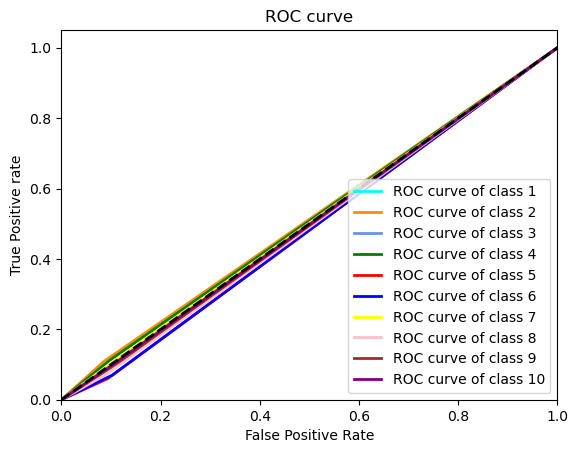

In [379]:
ROC(fpr_dict, tpr_dict)

In [370]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize

In [371]:
def ROC_Values(yTest,yPred):
    y_test = yTest; y_score = yPred
    y_score = label_binarize(y_score, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    y_test = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    n_classes = y_test.shape[1]
    
    fpr = dict()
    tpr = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])

    return fpr,tpr, n_classes

F,T,NC = ROC_Values(Yt,y_pred)

In [376]:
from itertools import cycle
def ROC_Curve(F,T, NC):
    fpr = F
    tpr = T
    n_classes = NC

    lw = 2
    plt.figure()

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green', 'red', 'blue', 'yellow', 'pink', 'brown', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0}'
                 ''.format(i+1))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Sklearn ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

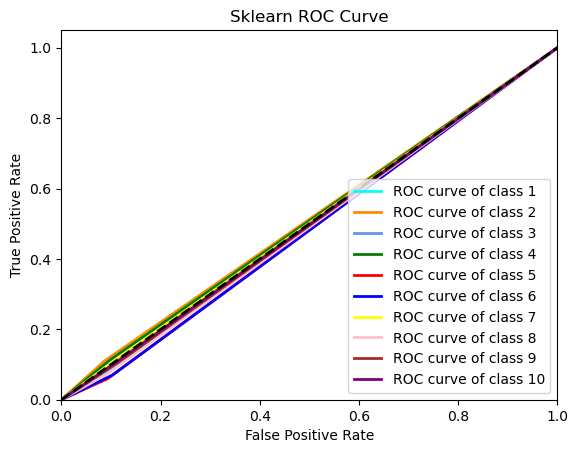

In [377]:
ROC_Curve(F, T, NC)

In [ ]:

def ROC_Values(y_test,y_score):

    n_classes = 10
    
    fpr = dict()
    tpr = dict()

    # Binarize the true labels
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])

    print(fpr,"\n")
    return fpr,tpr

FPR, TPR = ROC_Values(Yt,proba)